In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [4]:

filename = 'root://t3se01.psi.ch:1094//store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/19922B78-283B-CD48-8A3D-0308D48A824A.root'
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()


In [8]:
events.MET[0].tolist()

{'MetUnclustEnUpDeltaX': -0.33203125,
 'MetUnclustEnUpDeltaY': 1.23828125,
 'covXX': 776.0,
 'covXY': -140.5,
 'covYY': 550.0,
 'phi': 0.3990478515625,
 'pt': 79.87171173095703,
 'significance': 10.734375,
 'sumEt': 1242.0,
 'sumPtUnclustered': 668.0,
 'fiducialGenPhi': 0.077880859375,
 'fiducialGenPt': 36.34375}

In [18]:
events.Generator[7].tolist()

{'binvar': -1.0,
 'scalePDF': 141.3828125,
 'weight': 0.5115966796875,
 'x1': 0.06384658813476562,
 'x2': 0.0936737060546875,
 'xpdf1': 0.0,
 'xpdf2': 0.0,
 'id1': -1,
 'id2': 21}

In [43]:
events.LHEPart[(events.LHEPart.status==1)&(abs(events.LHEPart.pdgId)>10)&(abs(events.LHEPart.pdgId)<15)][3].tolist()

[{'pt': 44.146484375,
  'eta': -0.01976776123046875,
  'phi': -0.901947021484375,
  'mass': 0.0006694197654724121,
  'incomingpz': 0.0,
  'pdgId': -11,
  'status': 1,
  'spin': 1},
 {'pt': 36.724609375,
  'eta': -1.48870849609375,
  'phi': 0.4057464599609375,
  'mass': -0.000682145357131958,
  'incomingpz': 0.0,
  'pdgId': 12,
  'status': 1,
  'spin': -1}]

# Loading the exported dataset

In [112]:
df = load("../../output/jets_partons_leptons_training_dataset_v05/output_ttHTobb_2018.coffea")

In [113]:
df["cutflow"]

{'initial': {'ttHTobb': 9668000},
 'skim': {'ttHTobb': 1607845},
 'presel': {'ttHTobb': 777068},
 'semilep_LHE': {'ttHTobb': 584143}}

In [114]:
df["sumw"]

{'semilep_LHE': {'ttHTobb': 952.9547538368306}}

In [115]:
cs = df["columns"]['ttHTobb']["semilep_LHE"]

partons = ak.unflatten(ak.zip({"pt": cs["Parton_pt"].value,
                              "eta": cs["Parton_eta"].value,
                              "phi": cs["Parton_phi"].value,
                               "mass": cs["Parton_mass"].value,
                              "pdgId": cs["Parton_pdgId"].value, 
                              "prov": cs["Parton_provenance"].value},
                         with_name='Momentum4D'),
                     cs["Parton_N"].value)

partons_matched = ak.unflatten(ak.zip({"pt": cs["PartonMatched_pt"].value,
                              "eta": cs["PartonMatched_eta"].value,
                              "phi": cs["PartonMatched_phi"].value,
                              "mass": cs["PartonMatched_mass"].value,
                              "pdgId": cs["PartonMatched_pdgId"].value, 
                              "prov": cs["PartonMatched_provenance"].value},
                         with_name='Momentum4D'),
                     cs["PartonMatched_N"].value)

jets = ak.unflatten(ak.zip({"pt": cs["JetGood_pt"].value,
                              "eta": cs["JetGood_eta"].value,
                              "phi": cs["JetGood_phi"].value,
                              "btag": cs["JetGood_btagDeepFlavB"].value,
                              "m": np.zeros(cs["JetGood_btagDeepFlavB"].value.shape)},
                         with_name='Momentum4D'),
                     cs["JetGood_N"].value)

jets_matched = ak.unflatten(ak.zip({"pt": cs["JetGoodMatched_pt"].value,
                              "eta": cs["JetGoodMatched_eta"].value,
                              "phi": cs["JetGoodMatched_phi"].value,
                              "btag": cs["JetGoodMatched_btagDeepFlavB"].value,
                              "prov": cs["PartonMatched_provenance"].value,
                              "m": np.zeros(cs["PartonMatched_provenance"].value.shape)},
                         with_name='Momentum4D'),
                     cs["JetGoodMatched_N"].value)


generator_info = ak.zip({"pdgid1": cs["Generator_id1"].value,
                              "pdgid2": cs["Generator_id2"].value,
                              "x1": cs["Generator_x1"].value,
                              "x2": cs["Generator_x2"].value},
                         )


lepton_partons = ak.unflatten(ak.zip({"pt": cs["LeptonParton_pt"].value,
                              "eta": cs["LeptonParton_eta"].value,
                              "phi": cs["LeptonParton_phi"].value,
                              "mass": cs["LeptonParton_mass"].value,
                              "pdgId": cs["LeptonParton_pdgId"].value},
                         with_name='Momentum4D'),
                     cs["LeptonParton_N"].value)

In [96]:
np.ones(cs["LeptonParton_N"].value.shape, np.int64)*2

array([2, 2, 2, ..., 2, 2, 2])

In [97]:
cs["LeptonParton_N"].value.shape

(584143,)

(array([  7125.,  53096., 100889.,   7588.,      0.,      0.,      0.,
             0.,      0., 415445.]),
 array([-5. , -2.4,  0.2,  2.8,  5.4,  8. , 10.6, 13.2, 15.8, 18.4, 21. ]),
 <BarContainer object of 10 artists>)

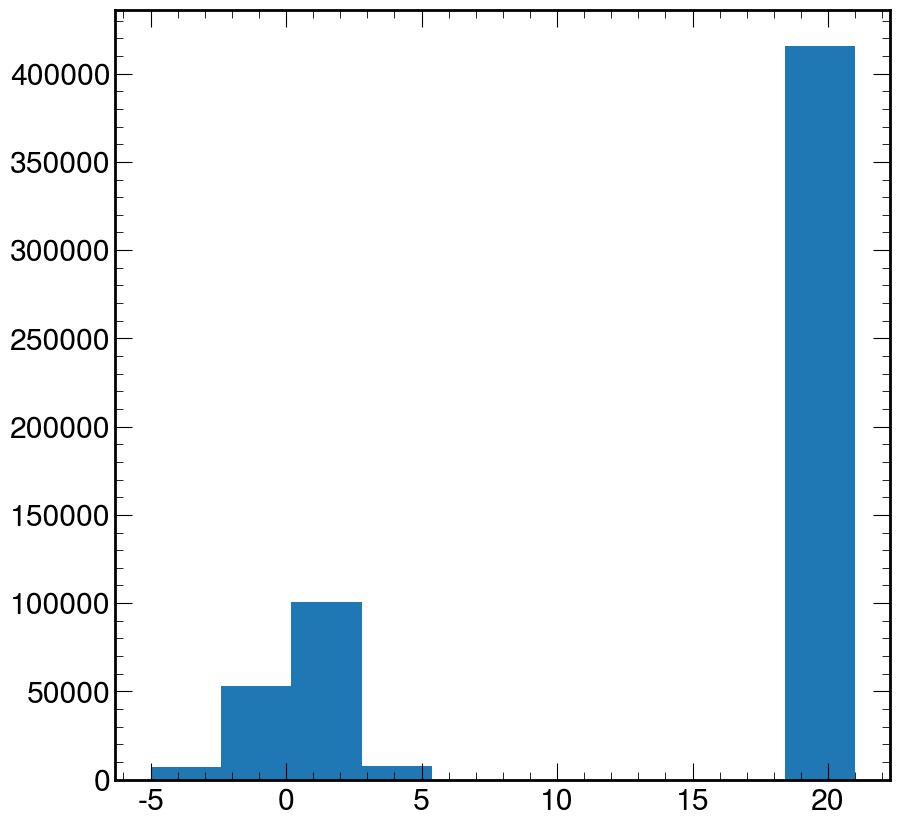

In [106]:
plt.hist(generator_info.pdgid1)

In [86]:
jets_matched = ak.mask(jets_matched, jets_matched.pt==-999, None)
partons_matched = ak.mask(partons_matched, partons_matched.pt==-999, None)
is_jet_matched = ~ak.is_none(jets_matched, axis=1)
jets = ak.with_field(jets, is_jet_matched, "matched")

# Filling with -1 the not matched provenance
jets = ak.with_field(jets, ak.fill_none(jets_matched.prov, -1), "prov")

Jets and partons_matched arrays are **aligned**.

In [116]:
df = ak.zip({
    "jets": jets,
    "partons_matched": partons_matched,
    "generator_info": generator_info,
    "lepton_partons":lepton_partons
    }, depth_limit=1)

ak.to_parquet(df, "all_jets_v3.parquet")